# **Importing** **Libaries**


In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

/content/drive/My Drive/PSR


In [4]:
#Import custom modules
from utils.eval_utils import get_generator, get_prediction
from utils.load_utils import init_models

#Other modules
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

#Supress Tensorflow Unnecessary Warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
#Define Constants
IMAGE_SIZE = (256,256)
FONT_SIZE = 16
BATCH_SIZE = 4
DPI = 600

#Data paths
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

In [6]:
#Load {index:classs_name} dictionary Function
def index_class_dict(): 
	file_names = os.listdir('ds/test/')
	file_names = sorted(file_names)
	index_class = {}
	for i in range(len(file_names)):
		index_class[i] = file_names[i]

	return index_class

#Save Figure Function
def savefigure(directory, fig_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + '/' + fig_name + '.tiff', bbox_inches='tight', dpi=DPI, format='tiff')

**Find Miss-Classified samples by KD-EfficientNetB0**

In [7]:
#Load required model
MODEL_NAME = 'KD-EfficientNetB0'
all_models = init_models([MODEL_NAME])
model = all_models[MODEL_NAME]['model']

#Set preprocessing and rescale
preprocess_func = all_models[MODEL_NAME]['preprocess_func']
rescale = all_models[MODEL_NAME]['rescale']

[INFO] Loading Model: KD-EfficientNetB0


In [8]:
print("[INFO] GET PREDICTIONS ON TEST SET\n")

#Get Sparse Generators
test_generator, nb_test_samples = get_generator(TEST_DATA_PATH, 'sparse', preprocess_input=preprocess_func , rescale=rescale)

print('Getting Predictions for ' + MODEL_NAME + ' on  Test Set')
#Get Testing Predictions
y_true, y_prob, y_soft_prob, y_pred = get_prediction(model, test_generator, nb_test_samples)

[INFO] GET PREDICTIONS ON TEST SET

Found 796 images belonging to 199 classes.
Getting Predictions for KD-EfficientNetB0 on  Test Set


In [9]:
#Load {class:index} dict
index_class = index_class_dict()
sample_index = dict()

#Count incorrect classified samples for each class
incorrect_samples={}
for i in range(len(index_class)):
    incorrect_samples[i] = [index_class[i], 0]
    sample_index[index_class[i]] = []

for i in range(nb_test_samples):
    if (y_true[i] != y_pred[i]):
        incorrect_samples[y_true[i]][1] += 1
        sample_index[index_class[y_true[i]]].append(i)

df_test = pd.DataFrame.from_dict(incorrect_samples, orient ='index')
df_test.rename(columns = {0:'Class Name', 1:'Incorrect Count (out of 4 test samples)'}, inplace = True)

print("[INFO] SHOW TOP 10 INCORRECT CLASSIFIED SAMPLES\n")
df_test.sort_values('Incorrect Count (out of 4 test samples)', ascending=False).head(10)

[INFO] SHOW TOP 10 INCORRECT CLASSIFIED SAMPLES



,Class Name,Incorrect Count (out of 4 test samples)
157,stenograph,4
46,extraordinary,3
173,unwillingly,3
57,future,3
125,peculiar,3
156,soonerorlater,2
97,letmehave,2
170,unexperience,2
175,valuable,2
29,counselforplaintiff,2


Found 796 images belonging to 199 classes.


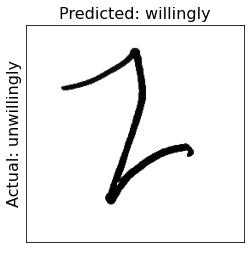

[INFO] Figure Saved


In [10]:
#List the class name of miss-classified sample
class_name = 'unwillingly'

#Get Sparse Generators
temp_generator, _ = get_generator(TEST_DATA_PATH, 'sparse')

#Set output path
OUTPUT_PATH = 'out/MISS_SAMPLES/'

#Save one sample from above class (if any sample is incorrectly classified) 
plt.rcParams.update({'font.size': FONT_SIZE})
if len(sample_index[class_name]) != 0: 
    index = sample_index[class_name][0]       
    orginal_sample = temp_generator[math.floor(index/BATCH_SIZE)][0][index%BATCH_SIZE]
    plt.imshow(orginal_sample/255.0)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Actual: " + index_class[y_true[index]])
    plt.title("Predicted: " + index_class[y_pred[index]], fontsize=FONT_SIZE)
    savefigure(OUTPUT_PATH, 'MISSCLASSIFIED-' + MODEL_NAME + '-' + class_name)
    plt.show()
    print("[INFO] Figure Saved")